Redefine the model to be w2 * t_u ** 2 + w1 * t_u + b.

Run a random number generate to have initial w1, w2, and b.

Redo p1ch5/1_parameter_estimation and p1ch5/2_autograd with the new model. Submit your programs and outcomes (including your initial values).

In [1]:
%matplotlib inline
import numpy as np
import torch
torch.set_printoptions(edgeitems=2)

In [2]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

In [3]:
def model(t_u, w1, w2, b):
    return w2 * t_u ** 2 + w1 * t_u + b

In [4]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

In [5]:
w1 = torch.rand(1, requires_grad=True)
w2 = torch.rand(1, requires_grad=True)
b = torch.rand(1, requires_grad=True)

t_p = model(t_u, w1, w2, b)
t_p

tensor([ 95.7117, 204.3922, 219.2684, 402.3469, 206.9426, 162.2638,  87.9417,
         43.8405, 159.4359, 233.9764, 291.4049], grad_fn=<AddBackward0>)

In [6]:
loss = loss_fn(t_p, t_c)
loss

tensor(40396.5625, grad_fn=<MeanBackward0>)

In [7]:
delta = 0.1

loss_rate_of_change_w1 = \
    (loss_fn(model(t_u, w1 + delta, w2, b), t_c) - 
     loss_fn(model(t_u, w1 - delta, w2, b), t_c)) / (2.0 * delta)

loss_rate_of_change_w2 = \
    (loss_fn(model(t_u, w1, w2 + delta, b), t_c) - 
     loss_fn(model(t_u, w1, w2 - delta, b), t_c)) / (2.0 * delta)

In [8]:
learning_rate = 1e-2

w1 = w1 - learning_rate * loss_rate_of_change_w1
w2 = w2 - learning_rate * loss_rate_of_change_w2

In [9]:
loss_rate_of_change_b = \
    (loss_fn(model(t_u, w1, w2, b + delta), t_c) - 
     loss_fn(model(t_u, w1, w2, b - delta), t_c)) / (2.0 * delta)

b = b - learning_rate * loss_rate_of_change_b

In [10]:
def dloss_fn(t_p, t_c):
    dsq_diffs = 2 * (t_p - t_c)
    return dsq_diffs

In [11]:
def dmodel_dw1(t_u, w1, w2, b):
    return t_u

In [12]:
def dmodel_dw2(t_u, w1, w2, b):
    return t_u ** 2

In [13]:
def dmodel_db(t_u, w1, w2, b):
    return 1.0

In [14]:
def grad_fn(t_u, t_c, t_p, w1, w2, b):
    dloss_dw1 = dloss_fn(t_p, t_c) * dmodel_dw1(t_u, w1, w2, b)
    dloss_dw2 = dloss_fn(t_p, t_c) * dmodel_dw2(t_u, w1, w2, b)
    dloss_db = dloss_fn(t_p, t_c) * dmodel_db(t_u, w1, w2, b)
    return torch.stack([dloss_dw1.mean(), dloss_dw2.mean(), dloss_db.mean()])

In [15]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        w1, w2, b = params

        t_p = model(t_u, w1, w2, b)  # <1>
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w1, w2, b)  # <2>

        params = params - learning_rate * grad

        print('Epoch %d, Loss %f' % (epoch, float(loss))) # <3>
            
    return params

In [16]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c, print_params=True):
    for epoch in range(1, n_epochs + 1):
        w1, w2, b = params

        t_p = model(t_u, w1, w2, b)  # <1>
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w1, w2, b)  # <2>

        params = params - learning_rate * grad

        if epoch in {1, 2, 3, 10, 11, 99, 100, 4000, 5000}:  # <3>
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            if print_params:
                print('    Params:', params)
                print('    Grad:  ', grad)
        if epoch in {4, 12, 101}:
            print('...')

        if not torch.isfinite(loss).all():
            break  # <3>
            
    return params

In [17]:
initial_params = torch.rand(3, requires_grad=True)
print("Initial params: %s" % initial_params)
training_loop(
    n_epochs = 100, 
    learning_rate = 1e-8 * 7, 
    params = initial_params,
    t_u = t_u,
    t_c = t_c)

Initial params: tensor([0.9215, 0.0391, 0.2149], requires_grad=True)
Epoch 1, Loss 28368.570312
    Params: tensor([ 0.9203, -0.0404,  0.2149], grad_fn=<SubBackward0>)
    Grad:   tensor([1.8065e+04, 1.1357e+06, 3.0514e+02], grad_fn=<StackBackward>)
Epoch 2, Loss 10403.631836
    Params: tensor([0.9210, 0.0075, 0.2149], grad_fn=<SubBackward0>)
    Grad:   tensor([-1.0346e+04, -6.8384e+05, -1.6256e+02], grad_fn=<StackBackward>)
Epoch 3, Loss 3890.196777
    Params: tensor([ 0.9205, -0.0213,  0.2149], grad_fn=<SubBackward0>)
    Grad:   tensor([6.7609e+03, 4.1175e+05, 1.1906e+02], grad_fn=<StackBackward>)
...
Epoch 10, Loss 188.464584
    Params: tensor([ 0.9205, -0.0102,  0.2149], grad_fn=<SubBackward0>)
    Grad:   tensor([ 1.4684e+02, -1.1822e+04,  1.0180e+01], grad_fn=<StackBackward>)
Epoch 11, Loss 186.512009
    Params: tensor([ 0.9205, -0.0107,  0.2149], grad_fn=<SubBackward0>)
    Grad:   tensor([ 442.4389, 7109.8389,   15.0460], grad_fn=<StackBackward>)
...
Epoch 99, Loss 184.72

tensor([ 0.9184, -0.0104,  0.2148], grad_fn=<SubBackward0>)

In [18]:
initial_params = torch.rand(3, requires_grad=True)
print("Initial params: %s" % initial_params)
training_loop(
    n_epochs = 100, 
    learning_rate = 1e-8, 
    params = initial_params, 
    t_u = t_u, 
    t_c = t_c)

Initial params: tensor([0.7379, 0.3151, 0.3891], requires_grad=True)
Epoch 1, Loss 1192180.875000
    Params: tensor([0.7368, 0.2413, 0.3891], grad_fn=<SubBackward0>)
    Grad:   tensor([1.1561e+05, 7.3860e+06, 1.9097e+03], grad_fn=<StackBackward>)
Epoch 2, Loss 708961.812500
    Params: tensor([0.7359, 0.1843, 0.3891], grad_fn=<SubBackward0>)
    Grad:   tensor([8.9211e+04, 5.6955e+06, 1.4751e+03], grad_fn=<StackBackward>)
Epoch 3, Loss 421624.468750
    Params: tensor([0.7352, 0.1404, 0.3891], grad_fn=<SubBackward0>)
    Grad:   tensor([6.8856e+04, 4.3920e+06, 1.1400e+03], grad_fn=<StackBackward>)
...
Epoch 10, Loss 11210.216797
    Params: tensor([0.7332, 0.0164, 0.3890], grad_fn=<SubBackward0>)
    Grad:   tensor([1.1396e+04, 7.1207e+05, 1.9413e+02], grad_fn=<StackBackward>)
Epoch 11, Loss 6718.842285
    Params: tensor([0.7332, 0.0109, 0.3890], grad_fn=<SubBackward0>)
    Grad:   tensor([8.8507e+03, 5.4910e+05, 1.5224e+02], grad_fn=<StackBackward>)
...
Epoch 99, Loss 130.399292
  

tensor([ 0.7326, -0.0076,  0.3890], grad_fn=<SubBackward0>)

In [19]:
t_un = 0.1 * t_u

In [20]:
initial_params = torch.rand(3, requires_grad=True)
print("Initial params: %s" % initial_params)
training_loop(
    n_epochs = 100, 
    learning_rate = 1e-8, 
    params = initial_params, 
    t_u = t_un, # <1>
    t_c = t_c)

Initial params: tensor([0.5405, 0.2297, 0.6867], requires_grad=True)
Epoch 1, Loss 18.028175
    Params: tensor([0.5405, 0.2297, 0.6867], grad_fn=<SubBackward0>)
    Grad:   tensor([ -15.4391, -146.7536,   -0.5143], grad_fn=<StackBackward>)
Epoch 2, Loss 18.027960
    Params: tensor([0.5405, 0.2297, 0.6867], grad_fn=<SubBackward0>)
    Grad:   tensor([ -15.4386, -146.7502,   -0.5142], grad_fn=<StackBackward>)
Epoch 3, Loss 18.027744
    Params: tensor([0.5405, 0.2297, 0.6867], grad_fn=<SubBackward0>)
    Grad:   tensor([ -15.4380, -146.7468,   -0.5141], grad_fn=<StackBackward>)
...
Epoch 10, Loss 18.026224
    Params: tensor([0.5405, 0.2298, 0.6867], grad_fn=<SubBackward0>)
    Grad:   tensor([ -15.4343, -146.7230,   -0.5135], grad_fn=<StackBackward>)
Epoch 11, Loss 18.026003
    Params: tensor([0.5405, 0.2298, 0.6867], grad_fn=<SubBackward0>)
    Grad:   tensor([ -15.4338, -146.7196,   -0.5134], grad_fn=<StackBackward>)
...
Epoch 99, Loss 18.006929
    Params: tensor([0.5406, 0.2299, 

tensor([0.5406, 0.2299, 0.6867], grad_fn=<SubBackward0>)

In [21]:
initial_params = torch.rand(3, requires_grad=True)
print("Initial params: %s" % initial_params)

params = training_loop(
    n_epochs = 5000, 
    learning_rate = 1e-8, 
    params = initial_params, 
    t_u = t_un, 
    t_c = t_c,
    print_params = False)

params

Initial params: tensor([0.0124, 0.0025, 0.9578], requires_grad=True)
Epoch 1, Loss 164.497421
Epoch 2, Loss 164.490219
Epoch 3, Loss 164.483002
...
Epoch 10, Loss 164.432571
Epoch 11, Loss 164.425369
...
Epoch 99, Loss 163.792892
Epoch 100, Loss 163.785706
...
Epoch 4000, Loss 138.222824
Epoch 5000, Loss 132.387268


tensor([0.0183, 0.0421, 0.9587], grad_fn=<SubBackward0>)

[1.5609219 2.3774357 2.4922094 3.934507  2.3970761 2.055554  1.5048482
 1.1987739 2.034142  2.6061645 3.0549266]
[ 0.5 14.  15.  28.  11.   8.   3.  -4.   6.  13.  21. ]


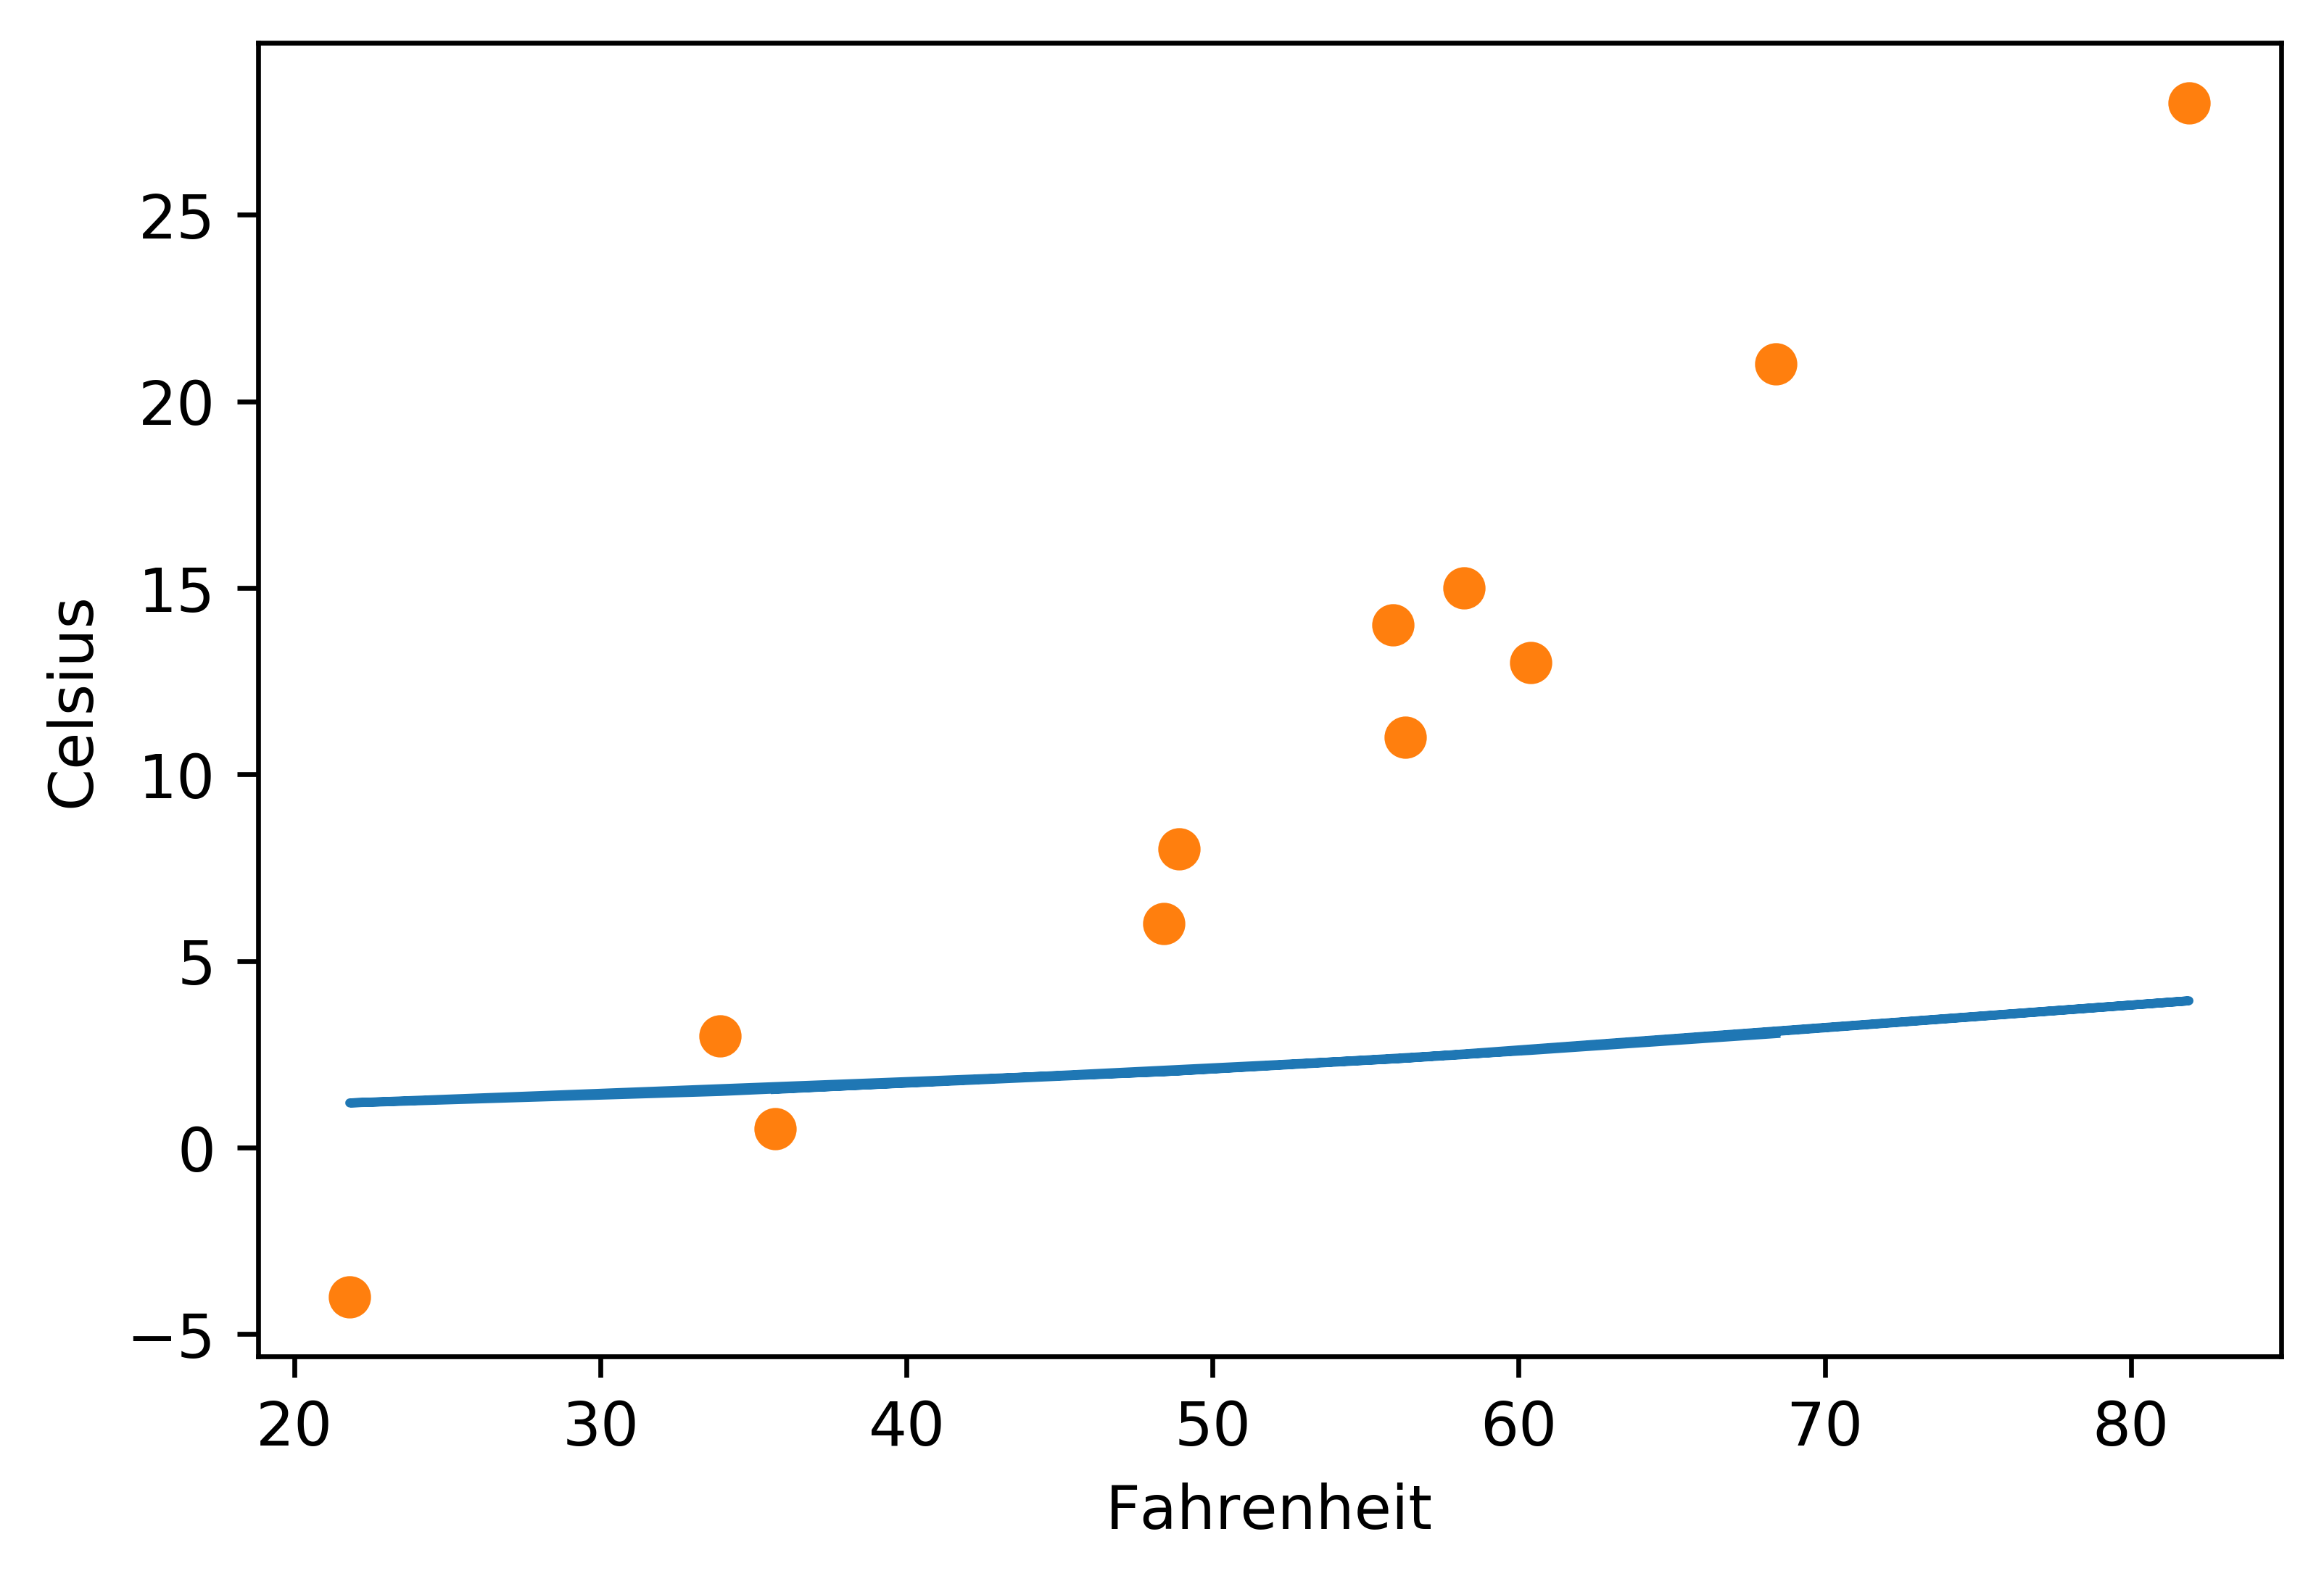

In [22]:
%matplotlib inline
from matplotlib import pyplot as plt

t_p = model(t_un, *params)  # <1>

fig = plt.figure(dpi=600)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
t_p_plot = t_p.detach().numpy()
plt.plot(t_u.numpy(), t_p_plot) # <2>
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
print(t_p_plot)
print(t_c.numpy())